# Introduction

# Import Library

In [107]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Import and Visulize Dataset

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
#Import Data
df = pd.read_csv("/content/drive/MyDrive/prediksi saham lstm/BBCA.JK.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-01,5200.0,5200.0,5200.0,5200.0,4629.854980,0
1,2019-01-02,5200.0,5245.0,5200.0,5240.0,4665.468262,35956000
2,2019-01-03,5200.0,5220.0,5115.0,5180.0,4612.046387,72358000
3,2019-01-04,5175.0,5205.0,5125.0,5205.0,4634.306152,51465000
4,2019-01-07,5265.0,5325.0,5245.0,5245.0,4669.920410,73438000


In [110]:
# Set Date as index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [111]:
# Check dataframe shape
df.shape

(1340, 6)

In [112]:
# Check dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1340 entries, 2019-01-01 to 2024-06-26
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1340 non-null   float64
 1   High       1340 non-null   float64
 2   Low        1340 non-null   float64
 3   Close      1340 non-null   float64
 4   Adj Close  1340 non-null   float64
 5   Volume     1340 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 73.3 KB


In [113]:
# Check missing values
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Dataset Visualization

### High and Low

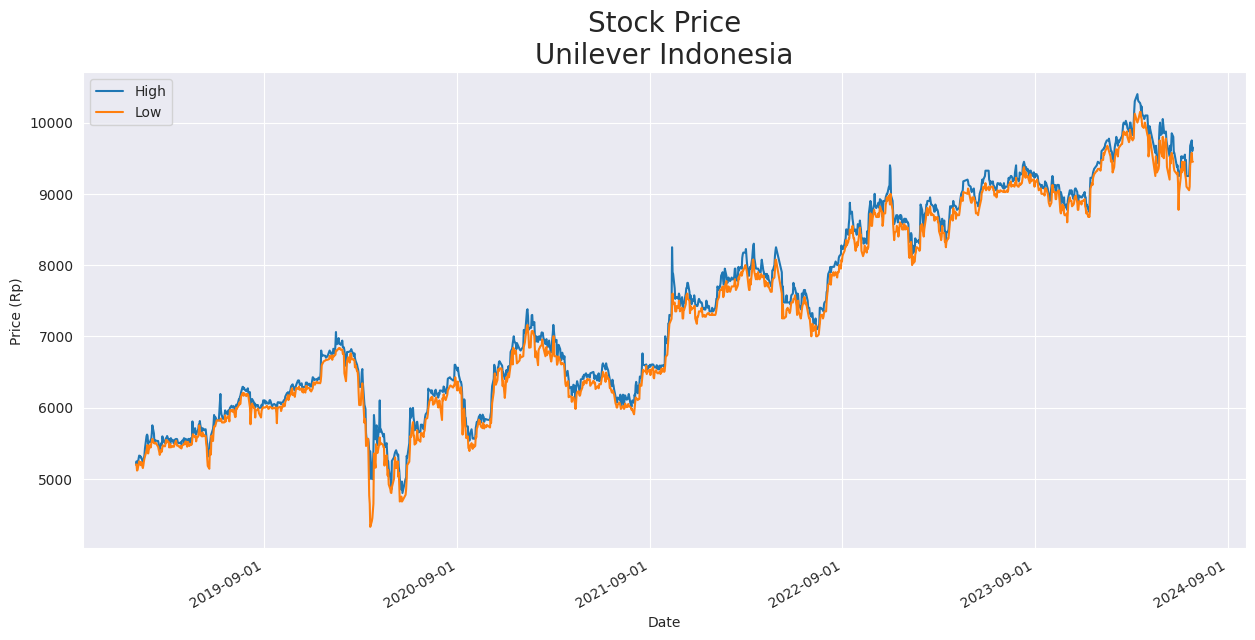

In [114]:
sns.set_style('darkgrid')
plt.figure(figsize=(15,7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
x_dates = df.index.values

plt.plot(x_dates, df['High'], label='High')
plt.plot(x_dates, df['Low'], label='Low')
plt.xlabel('Date')
plt.ylabel('Price (Rp)')
plt.title("Stock Price\nUnilever Indonesia", fontsize=20)
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

### Open and Close

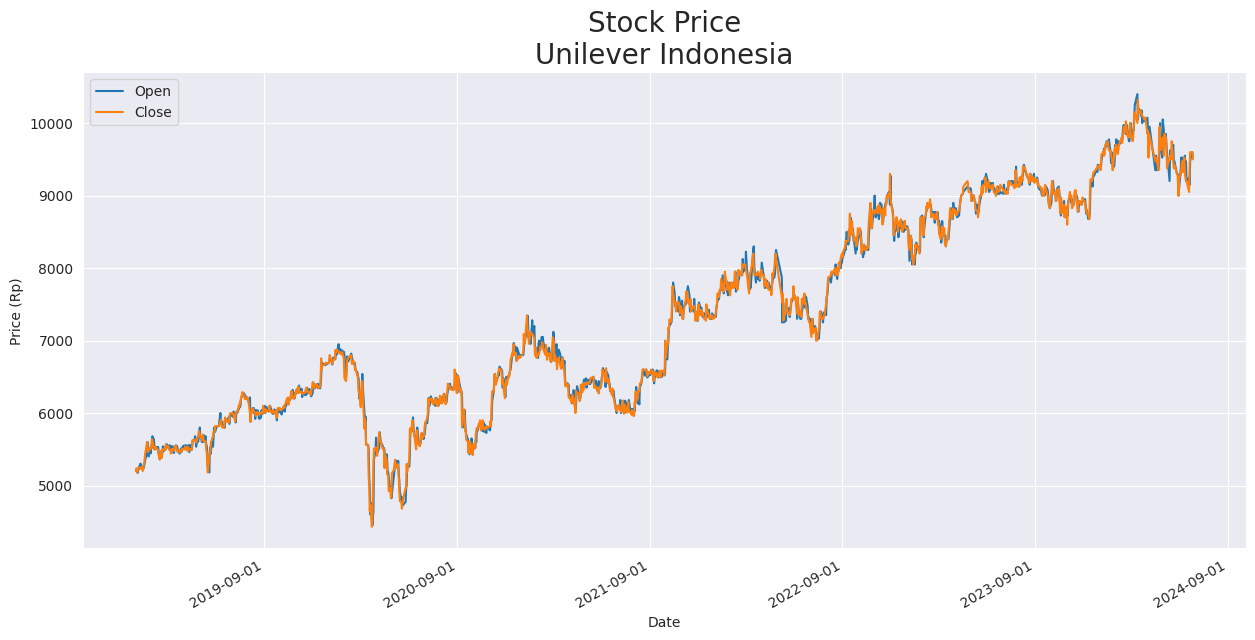

In [115]:
plt.figure(figsize=(15,7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))

plt.plot(x_dates, df['Open'], label='Open')
plt.plot(x_dates, df['Close'], label='Close')
plt.xlabel('Date')
plt.ylabel('Price (Rp)')
plt.title("Stock Price\nUnilever Indonesia", fontsize=20)
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

### Close and Adj Close

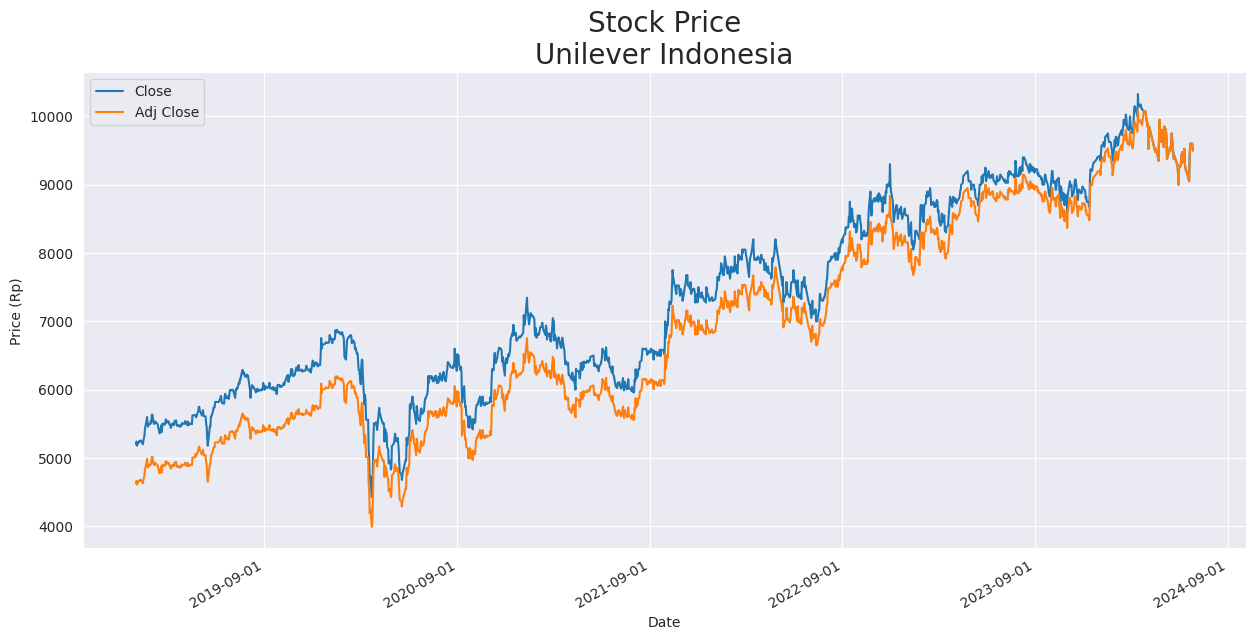

In [116]:
plt.figure(figsize=(15,7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))

plt.plot(x_dates, df['Close'], label='Close')
plt.plot(x_dates, df['Adj Close'], label='Adj Close')
plt.xlabel('Date')
plt.ylabel('Price (Rp)')
plt.title("Stock Price\nUnilever Indonesia", fontsize=20)
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

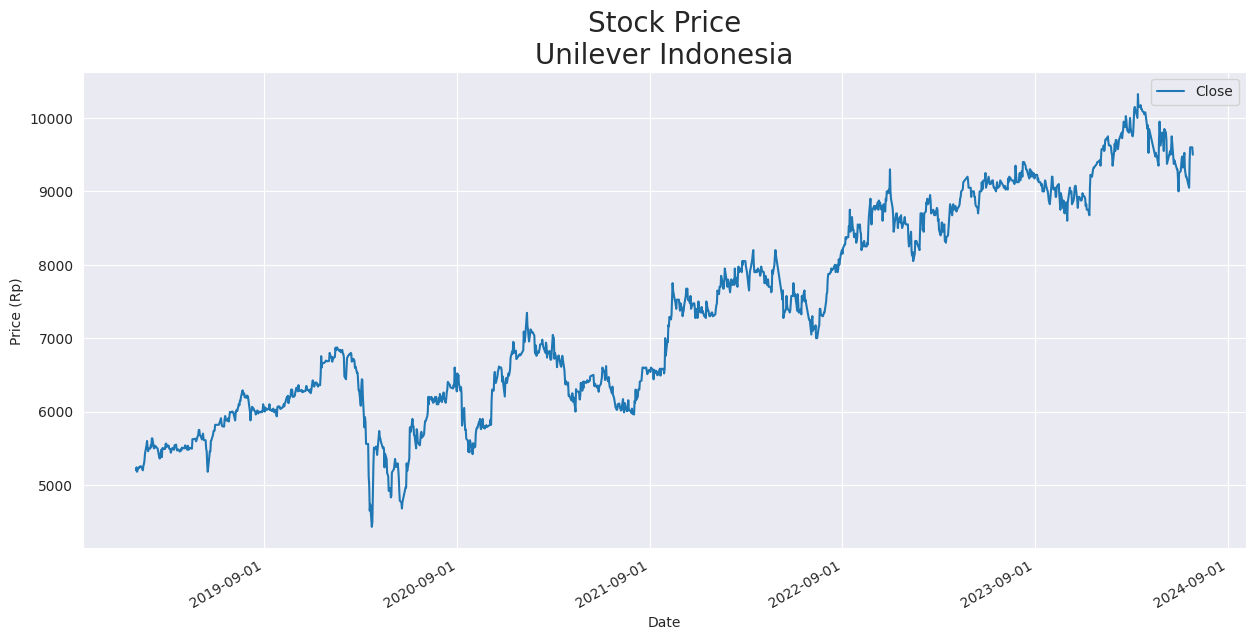

In [117]:
plt.figure(figsize=(15,7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))

plt.plot(x_dates, df['Close'], label='Close')
plt.xlabel('Date')
plt.ylabel('Price (Rp)')
plt.title("Stock Price\nUnilever Indonesia", fontsize=20)
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

# Data Preprocessing

## Feature Scaling

In [118]:
#MinMaxScaler
ms = MinMaxScaler()
df['Close_ms'] = ms.fit_transform(df[['Close']])

## Split Data

In [119]:
def split_data(df, train_size):
  size = int(len(df) * train_size)
  train, test = df.iloc[0:size], df.iloc[size:len(df)]
  return train, test

In [120]:
train, test = split_data(df['Close_ms'], 0.8) #80% Train

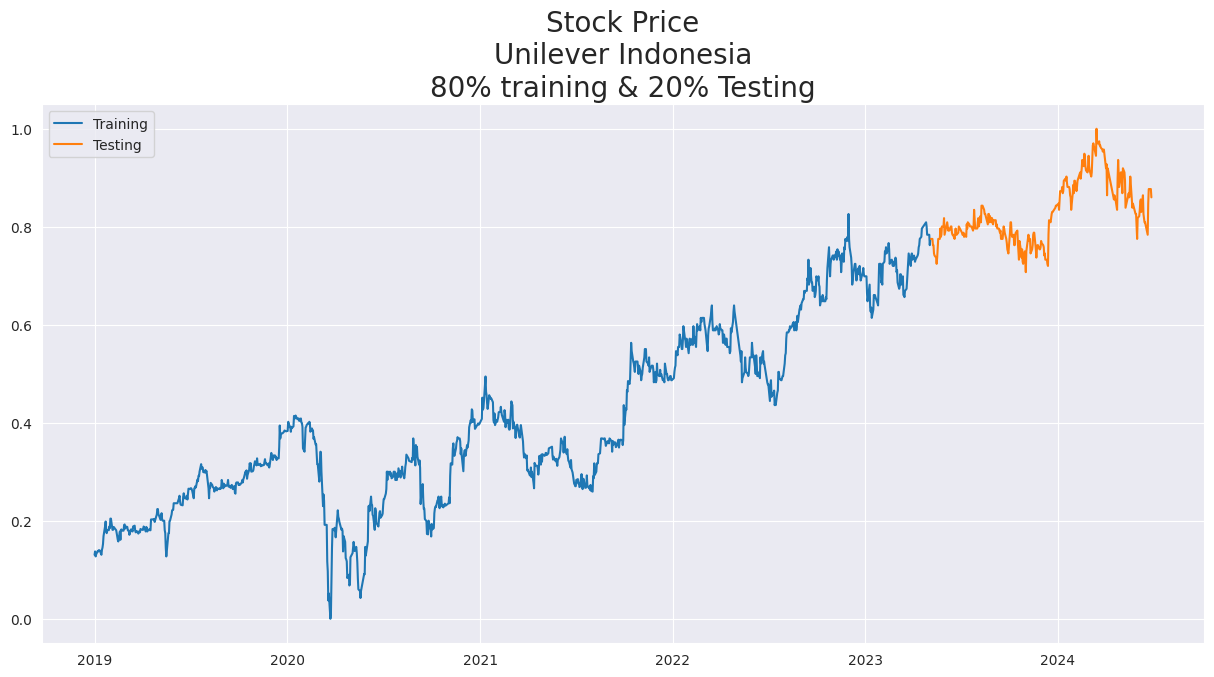

In [121]:
plt.figure(figsize=(15,7))
plt.plot(train)
plt.plot(test)
plt.legend(labels=['Training', 'Testing'])
plt.title('Stock Price\nUnilever Indonesia\n80% training & 20% Testing', fontsize=20)
plt.show()

In [122]:
def split_target(df, look_back=1):
    X, y = [], []
    for i in range(len(df) - look_back):
        a = df[i:(i + look_back), 0]
        X.append(a)
        y.append(df[i + look_back, 0])
    return np.array(X), np.array(y)

In [123]:
X_train, y_train = split_target(train.values.reshape(len(train), 1))
X_test, y_test = split_target(test.values.reshape(len(test), 1))

In [124]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build Model

In [125]:
# Callbacks
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_mae') is not None and logs.get('val_mae') < 0.01:
      self.model.stop_training = True

In [126]:
model = Sequential([LSTM(128, input_shape=(1, 1), return_sequences=True),
                    Dropout(0.2),
                    LSTM(64),
                    Dropout(0.2),
                    Dense(32, activation='relu'),
                    Dense(1)])

In [127]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1, 128)            66560     
                                                                 
 dropout_8 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 118081 (461.25 KB)
Trainable params: 118

In [128]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              metrics=["mae"],
              loss=tf.keras.losses.Huber())

# Training

In [129]:
history = model.fit(X_train,
                    y_train,
                    epochs=200,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    shuffle=False,
                    callbacks=[Callback()])

Epoch 1/200
34/34 [==============================] - 7s 42ms/step - loss: 0.0898 - mae: 0.3868 - val_loss: 0.3120 - val_mae: 0.7875
Epoch 2/200
34/34 [==============================] - 0s 9ms/step - loss: 0.0761 - mae: 0.3512 - val_loss: 0.2785 - val_mae: 0.7438
Epoch 3/200
34/34 [==============================] - 0s 9ms/step - loss: 0.0626 - mae: 0.3132 - val_loss: 0.2420 - val_mae: 0.6931
Epoch 4/200
34/34 [==============================] - 0s 10ms/step - loss: 0.0488 - mae: 0.2701 - val_loss: 0.2016 - val_mae: 0.6324
Epoch 5/200
34/34 [==============================] - 0s 8ms/step - loss: 0.0351 - mae: 0.2201 - val_loss: 0.1587 - val_mae: 0.5606
Epoch 6/200
34/34 [==============================] - 0s 8ms/step - loss: 0.0233 - mae: 0.1699 - val_loss: 0.1174 - val_mae: 0.4817
Epoch 7/200
34/34 [==============================] - 0s 10ms/step - loss: 0.0149 - mae: 0.1311 - val_loss: 0.0833 - val_mae: 0.4052
Epoch 8/200
34/34 [==============================] - 0s 13ms/step - loss: 0.0106

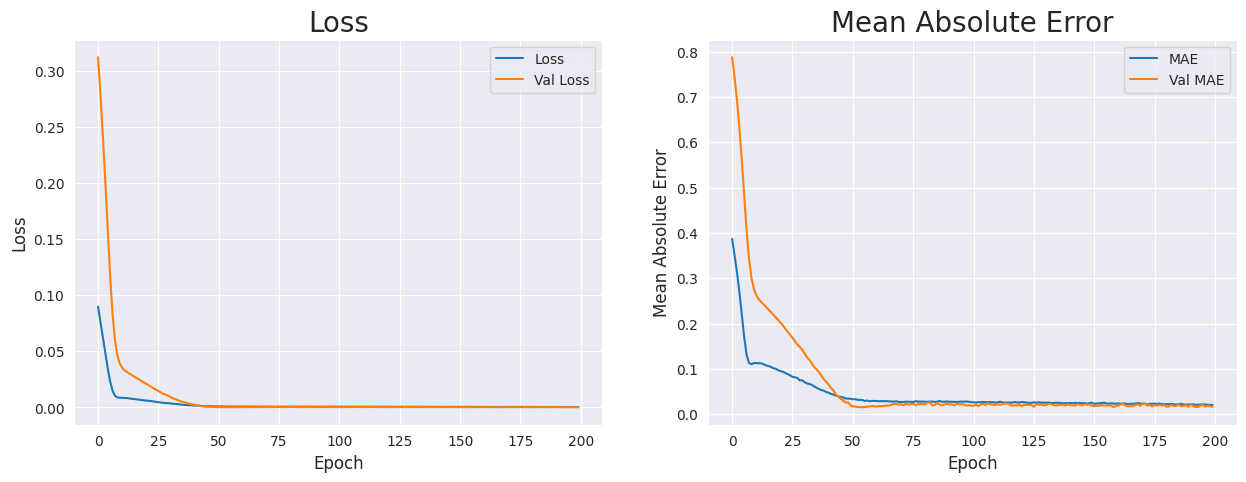

In [131]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Loss', 'Val Loss'])
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss', fontsize=20)

# Plot MAE
ax2.plot(history.history['mae'])
ax2.plot(history.history['val_mae'])
ax2.legend(['MAE', 'Val MAE'])
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Mean Absolute Error', fontsize=12)
ax2.set_title('Mean Absolute Error', fontsize=20)
plt.show()

# Predict

9/9 [==============================] - 2s 5ms/step


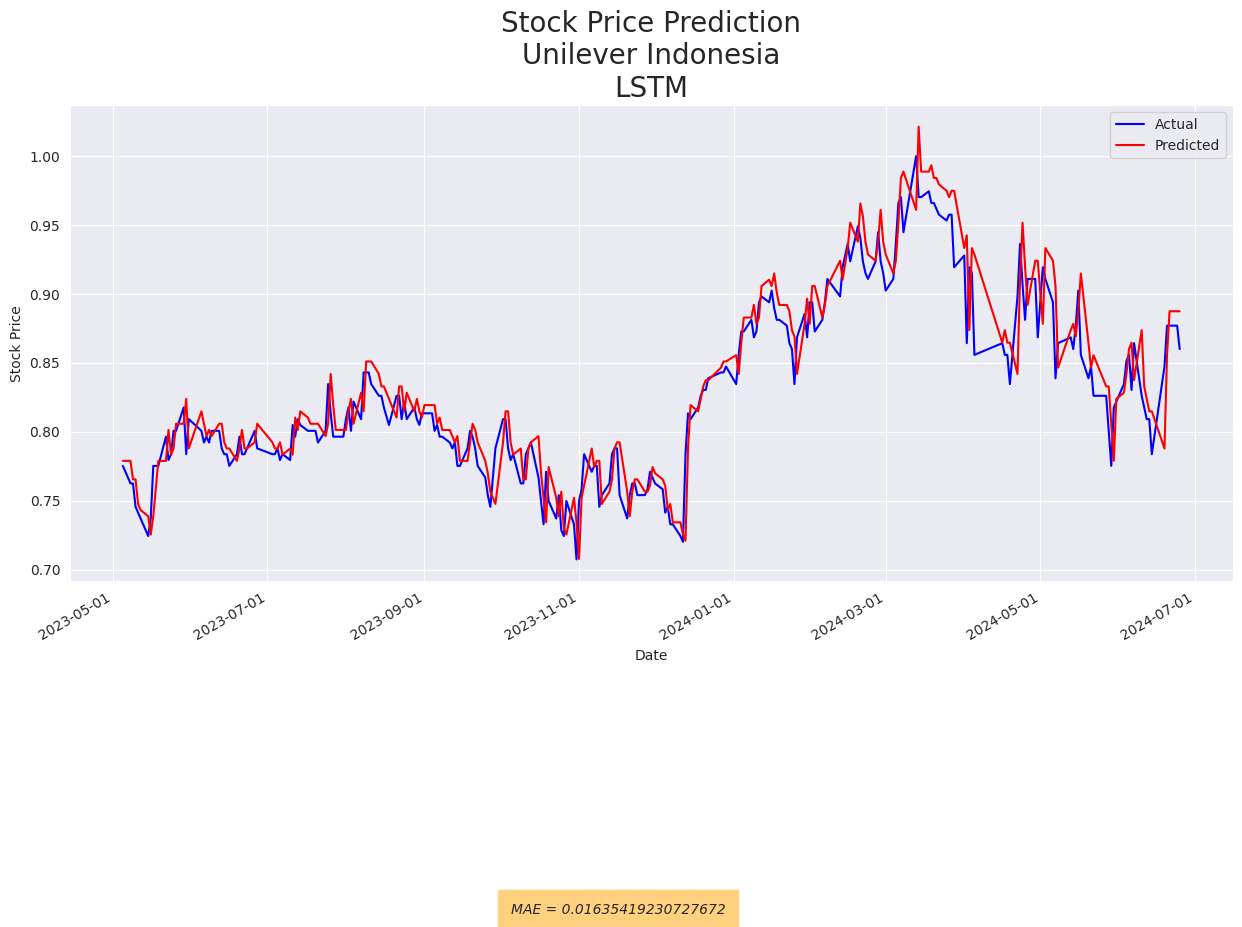

In [132]:
# Perform prediction on the test data
pred = model.predict(X_test)
y_pred = np.array(pred).reshape(-1)

# Plot the actual and predicted prices
plt.figure(figsize=(15, 7))
plt.plot(test.index[:-1], y_test, color='blue', label='Actual')  # Exclude the last element to match the length
plt.plot(test.index[:-1], y_pred, color='red', label='Predicted')  # Exclude the last element to match the length

# Choose an x-coordinate within the bounds of your data
index_for_text = 100  # Example: Choose index 100
plt.text(test.index[index_for_text], 0.45, f"MAE = {mean_absolute_error(y_test, y_pred)}", style='italic', bbox={
        'facecolor': 'orange', 'alpha': 0.5, 'pad': 10})
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction\nUnilever Indonesia\nLSTM', fontsize=20)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

## Evaluation

In [133]:
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
print('MAE: ', mae)
print('RSME: ', rmse)
print('MAPE: ', mape)

MAE:  0.01635419230727672
RSME:  0.021522383795659766
MAPE:  0.01962257534426982


# Plot all data with predicted result

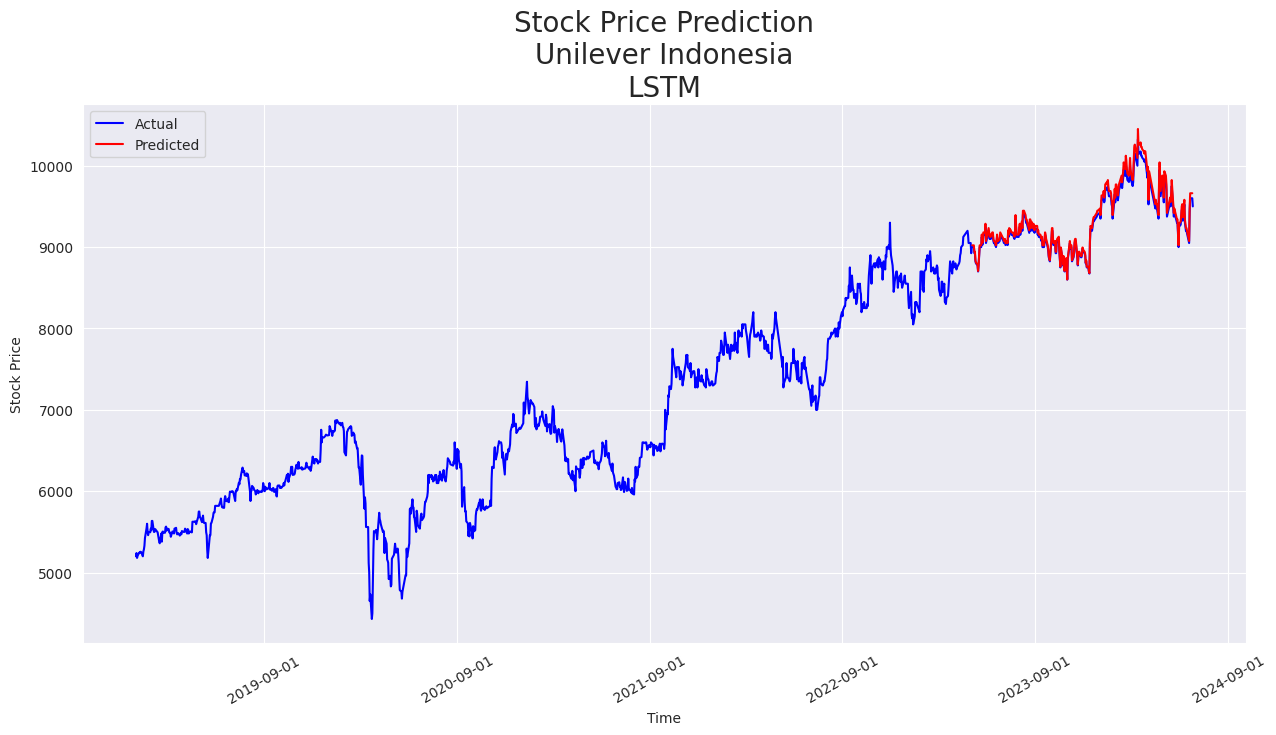

In [134]:
# Inverse transform the predicted values
y_pred_original = ms.inverse_transform(np.array(y_pred).reshape(-1, 1))

# Extract the predicted values as a 1D array
y_pred_original = y_pred_original.flatten()  # Flatten the 2D array to 1D

# Plot the actual and predicted prices
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['Close'], color='blue', label='Actual')

# Adjust the x-axis for predicted values to match the available predictions, exclude last element of df.index
plt.plot(df.index[len(train.index):-1], y_pred_original, color='red', label='Predicted')  # Start plotting from where training data ends, and exclude last element

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction\nUnilever Indonesia\nLSTM', fontsize=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
# Rotate x-axis labels
plt.xticks(rotation=30)

plt.legend()
plt.show()